In [1]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

# Deep Agent for Research

## Overview 

<img src="./assets/agent_header.png" width="800" style="display:block; margin-left:0;">

Now, we can put everything we have learned together:

* We will use **TODOs** to keep track of tasks. 
* We will use **files** to store raw tool call results. 
* We will **delegate research tasks to sub-agents** for context isolation. 

## Search Tool 

We'll build a search tool that offloads raw contents to files and returns only a summary to the agent. This is a common pattern for long-running agent trajectories, [as we've seen with Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus)! 

### Core Components

1. **Search Execution (`run_tavily_search`)**: Performs the actual web search using Tavily API with configurable parameters for results count and topic filtering.

2. **Content Summarization (`summarize_webpage_content`)**: Uses a lightweight model (GPT-4o-mini) to generate structured summaries of webpage content, producing both a descriptive filename and key learnings summary.

3. **Result Processing (`process_search_results`)**: Fetches full webpage content via HTTP, converts HTML to markdown using `markdownify`, and generates summaries for each result.

4. **Context Offloading (`tavily_search` tool)**: The main tool that:
   - Executes search and processes results
   - Saves full content to files in agent state (context offloading)
   - Returns only minimal summaries to the agent (prevents context spam)
   - Uses LangGraph `Command` to update both files and messages

5. **Strategic Thinking (`think_tool`)**: Provides a structured reflection mechanism for agents to analyze findings, assess gaps, and plan next steps in their research workflow.

This architecture solves the token efficiency problem by storing detailed search results in files while keeping the agent's working context minimal and focused.

In [2]:
%%writefile ../src/deep_agents_from_scratch/research_tools.py
"""Research Tools.

This module provides search and content processing utilities for the research agent,
including web search capabilities and content summarization tools.
"""
import os
from datetime import datetime
import uuid, base64

import httpx
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.tools import InjectedToolArg, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from markdownify import markdownify
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing_extensions import Annotated, Literal
from langchain_sambanova import ChatSambaNova

from deep_agents_from_scratch.prompts import SUMMARIZE_WEB_SEARCH
from deep_agents_from_scratch.state import DeepAgentState

# Summarization model 
#summarization_model = init_chat_model(model="openai:gpt-4o-mini")
summarization_model = ChatSambaNova(model="DeepSeek-V3.1-Terminus", temperature=0.0, extra_body={"chat_template_kwargs": {"enable_thinking": False}})
tavily_client = TavilyClient()

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    filename: str = Field(description="Name of the file to store.")
    summary: str = Field(description="Key learnings from the webpage.")

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

def run_tavily_search(
    search_query: str, 
    max_results: int = 1, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
) -> dict:
    """Perform search using Tavily API for a single query.

    Args:
        search_query: Search query to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        Search results dictionary
    """
    result = tavily_client.search(
        search_query,
        max_results=max_results,
        include_raw_content=include_raw_content,
        topic=topic
    )

    return result

def summarize_webpage_content(webpage_content: str) -> Summary:
    """Summarize webpage content using the configured summarization model.
    
    Args:
        webpage_content: Raw webpage content to summarize
        
    Returns:
        Summary object with filename and summary
    """
    try:
        # Set up structured output model for summarization
        structured_model = summarization_model.with_structured_output(Summary)
        
        # Generate summary
        summary_and_filename = structured_model.invoke([
            HumanMessage(content=SUMMARIZE_WEB_SEARCH.format(
                webpage_content=webpage_content, 
                date=get_today_str()
            ))
        ])
        
        return summary_and_filename
        
    except Exception:
        # Return a basic summary object on failure
        return Summary(
            filename="search_result.md",
            summary=webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content
        )

def process_search_results(results: dict) -> list[dict]:
    """Process search results by summarizing content where available.
    
    Args:
        results: Tavily search results dictionary
        
    Returns:
        List of processed results with summaries
    """
    processed_results = []

    # Create a client for HTTP requests
    HTTPX_CLIENT = httpx.Client()
    
    for result in results.get('results', []):
        
        # Get url 
        url = result['url']
        
        # Read url
        response = HTTPX_CLIENT.get(url)

        if response.status_code == 200:
            # Convert HTML to markdown
            raw_content = markdownify(response.text)
            summary_obj = summarize_webpage_content(raw_content)
        else:
            # Use Tavily's generated summary
            raw_content = result.get('raw_content', '')
            summary_obj = Summary(
                filename="URL_error.md",
                summary=result.get('content', 'Error reading URL; try another search.')
            )
        
        # uniquify file names
        uid = base64.urlsafe_b64encode(uuid.uuid4().bytes).rstrip(b"=").decode("ascii")[:8]
        name, ext = os.path.splitext(summary_obj.filename)
        summary_obj.filename = f"{name}_{uid}{ext}"

        processed_results.append({
            'url': result['url'],
            'title': result['title'],
            'summary': summary_obj.summary,
            'filename': summary_obj.filename,
            'raw_content': raw_content,
        })
    
    return processed_results

@tool(parse_docstring=True)
def tavily_search(
    query: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
    max_results: Annotated[int, InjectedToolArg] = 1,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> Command:
    """Search web and save detailed results to files while returning minimal context.

    Performs web search and saves full content to files for context offloading.
    Returns only essential information to help the agent decide on next steps.

    Args:
        query: Search query to execute
        state: Injected agent state for file storage
        tool_call_id: Injected tool call identifier
        max_results: Maximum number of results to return (default: 1)
        topic: Topic filter - 'general', 'news', or 'finance' (default: 'general')

    Returns:
        Command that saves full results to files and provides minimal summary
    """
    # Execute search
    search_results = run_tavily_search(
        query,
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    ) 

    # Process and summarize results
    processed_results = process_search_results(search_results)
    
    # Save each result to a file and prepare summary
    files = state.get("files", {})
    saved_files = []
    summaries = []
    
    for i, result in enumerate(processed_results):
        # Use the AI-generated filename from summarization
        filename = result['filename']
        
        # Create file content with full details
        file_content = f"""# Search Result: {result['title']}

**URL:** {result['url']}
**Query:** {query}
**Date:** {get_today_str()}

## Summary
{result['summary']}

## Raw Content
{result['raw_content'] if result['raw_content'] else 'No raw content available'}
"""
        
        files[filename] = file_content
        saved_files.append(filename)
        summaries.append(f"- {filename}: {result['summary']}...")
    
    # Create minimal summary for tool message - focus on what was collected
    summary_text = f"""🔍 Found {len(processed_results)} result(s) for '{query}':

{chr(10).join(summaries)}

Files: {', '.join(saved_files)}
💡 Use read_file() to access full details when needed."""

    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(summary_text, tool_call_id=tool_call_id)
            ],
        }
    )

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.

    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.

    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    - How complex is the question: Have I reached the number of search limits?

    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?

    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps

    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"

Overwriting ../src/deep_agents_from_scratch/research_tools.py


## Deep Agent

Now, we can just apply all of our prior learnings: 

* We'll give the researcher a `think_tool` and our `search_tool` above.
* We'll give our parent agent file tools, a `think_tool`, and a `task` tool. 

In [47]:
from datetime import datetime

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
from utils import show_prompt, stream_agent

from deep_agents_from_scratch.file_tools import ls, read_file, write_file
from deep_agents_from_scratch.prompts import (
    FILE_USAGE_INSTRUCTIONS,
    RESEARCHER_INSTRUCTIONS,
    SUBAGENT_USAGE_INSTRUCTIONS,
    TODO_USAGE_INSTRUCTIONS,
)
from deep_agents_from_scratch.research_tools import tavily_search, think_tool, get_today_str
from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.task_tool import _create_task_tool
from deep_agents_from_scratch.todo_tools import write_todos, read_todos
from langchain_sambanova import ChatSambaNova

# Create agent using create_react_agent directly
#model = init_chat_model(model="anthropic:claude-sonnet-4-20250514", temperature=0.0)
model = ChatSambaNova(model="DeepSeek-V3.1-Terminus", temperature=0.0, extra_body={"chat_template_kwargs": {"enable_thinking": False}})

# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Tools
sub_agent_tools = [tavily_search, think_tool]
built_in_tools = [ls, read_file, write_file, write_todos, read_todos, think_tool]

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": RESEARCHER_INSTRUCTIONS.format(date=get_today_str()),
    "tools": ["tavily_search", "think_tool"],
}

# Create task tool to delegate tasks to sub-agents
task_tool = _create_task_tool(
    sub_agent_tools, [research_sub_agent], model, DeepAgentState
)

delegation_tools = [task_tool]
all_tools = sub_agent_tools + built_in_tools + delegation_tools  # search available to main agent for trivial cases

# Build prompt
SUBAGENT_INSTRUCTIONS = SUBAGENT_USAGE_INSTRUCTIONS.format(
    max_concurrent_research_units=max_concurrent_research_units,
    max_researcher_iterations=max_researcher_iterations,
    date=datetime.now().strftime("%a %b %-d, %Y"),
)

/Users/kwasia/Documents/Projects/deep-agents-from-scratch/.venv/lib/python3.11/site-packages/pydantic/main.py:253: UserWarning: WARNING! extra_body is not default parameter.
                    extra_body was transferred to model_kwargs.
                    Please confirm that extra_body is what you intended.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


In [48]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 1-2 search tool calls maximum                                                        │
│  - **Normal queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Very Complex queries**: Use up to 5 search tool calls maximum                                              │
│  - **Always stop**: After 5 search tool calls if you c

In [49]:
INSTRUCTIONS = (
    "# TODO MANAGEMENT\n"
    + TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# FILE SYSTEM USAGE\n"
    + FILE_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# SUB-AGENT DELEGATION\n"
    + SUBAGENT_INSTRUCTIONS
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # TODO MANAGEMENT                                                                                              │
│  Based upon the user's request:                                                                                 │
│  1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.           │
│  2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan.  │
│  3. Reflect on what you've done and the TODO.                                                                   │
│  4. Mark you task as completed, and proceed to the next TODO.                                                   │
│  5. Continue this process until you have completed all TODOs.                                                   │
│                                                                                                                 │
│  IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY  │
│  user request.                                                                                                  │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # FILE SYSTEM USAGE                                                                                            │
│  You have access to a virtual file system to help you retain and save context.                                  │
│                                                                                                                 │
│  ## Workflow Process                                                                                            │
│  1. **Orient**: Use ls() to see existing files before starting work                                             │
│  2. **Save**: Use write_file() to store the user's request so that we can keep it for later                     │
│  3. **Research**: Proceed with research. The search tool will write files.                                      │
│  4. **Read**: Once you are satisfied with the collected sources, read the files and use them to answer the      │
│  user's question directly.                                                                                      │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # SUB-AGENT DELEGATION                                                                                         │
│  You can delegate tasks to sub-agents.                                                                          │
│                                                                                                                 │
│  <Task>                                               

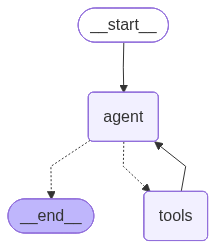

In [50]:
# Create agent
agent = create_react_agent(
    model, all_tools, prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [51]:
from utils import format_messages

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, and core concepts",              │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Investigate MCP architecture, components, and how it works",                                  │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Explore use cases, benefits, and real-world applications of MCP",                             │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research MCP implementation details and technical specifications",                            │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Compile comprehensive overview and present findings",                                         │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_9703be6cea234b29aa                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) - definition, purpose, and core        │
│ concepts', 'status': 'pending'}, {'content': 'Investigate MCP architecture, components, and how it works',      │
│ 'status': 'pending'}, {'content': 'Explore use cases, benefits, and real-world applications of MCP', 'status':  │
│ 'pending'}, {'content': 'Research MCP implementation details and technical specifications', 'status':           │
│ 'pending'}, {'content': 'Compile comprehensive overview and present findings', 'status': 'pending'}]            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research Model Context Protocol (MCP) - definition, purpose, core concepts, and what problem  │
│ it solves",                                                                                                     │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: call_5d07ed01416944a3b7                                                                                  │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Investigate MCP architecture, components, technical specifications, and how the protocol      │
│ works",                                                                                                         │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: call_5a9f9da8c5634343a9                                                                                  │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Explore MCP use cases, benefits, real-world applications, and implementation examples",       │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: call_03bcd4274f964c96b9                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my research, here's a comprehensive overview of the Model Context Protocol (MCP):                      │
│                                                                                                                 │
│ ## Definition                                                                                                   │
│ **Model Context Protocol (MCP)** is an open-source client-server protocol standard designed specifically for    │
│ connecting AI applications and agents to external systems, data sources, and tools. It serves as a standardized │
│ interface that enables seamless communication between AI models and various external services.                  │
│                                                                                                                 │
│ ## Purpose                                                                                                      │
│ The primary purpose of MCP is to:                                                                               │
│ - **Reduce development time and complexity** when building or integrating AI applications                       │
│ - **Provide AI applications/agents** with access to an ecosystem of data sources, tools, and applications       │
│ - **Enhance AI capabilities** and improve end-user experience through standardized external integrations        │
│ - **Establish common standards** for context-related tasks in AI development                                    │
│                                                                                                                 │
│ ## Core Concepts and Architecture                                                                               │
│                                                                                                                 │
│ ### Layered Architecture                                                                                        │
│ MCP operates on a layered architecture:                                                                         │
│ - **Data Layer**: Uses JSON-RPC protocol for handling tools, resources, and prompts                             │
│ - **Transport Layer**: Supports stdio and HTTP communication methods                                            │
│                                                                                                                 │
│ ### Key Components                                                                                              │
│ 1. **MCP Servers**: Expose data, tools, and capabilities to AI applications                                     │
│ 2. **MCP Clients**: AI applications that connect to MCP servers to access external resources                    │
│ 3. **Tools**: External capabilities that AI applications can invoke through the protocol                        │
│ 4. **Resources**: Data sources and content that can be accessed by AI applications                              │
│ 5. **Prompts**: Structured prompt templates (including slash commands) that servers can expose to clients       │
│                                                                                                                 │
│ ### Technical Features                                                                                          │
│ - **Capability Negotiation**: Dynamic discovery and negotiation of available features                           │
│ - **Real-time Notifications**: Enables dynamic tool discovery and execution                                     │
│ - **Structured Templates**: User-controlled prompt templates supporting text, images, audio, and embedded       │
│ resources                                                                                                       │
│                                                        

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my research, here's a comprehensive overview of the Model Context Protocol (MCP) architecture,         │
│ components, technical specifications, and protocol workflow:                                                    │
│                                                                                                                 │
│ ## MCP Architecture Overview                                                                                    │
│                                                                                                                 │
│ The Model Context Protocol (MCP) is a client-server protocol designed for AI applications to exchange context   │
│ with external services. It features a **layered architecture** with two main layers:                            │
│                                                                                                                 │
│ ### 1. Data Layer                                                                                               │
│ - **Protocol**: JSON-RPC 2.0 specification                                                                      │
│ - **Message Types**: Tools, resources, and prompts                                                              │
│ - **Capability Negotiation**: Dynamic discovery of available capabilities                                       │
│                                                                                                                 │
│ ### 2. Transport Layer                                                                                          │
│ - **Primary Transport**: stdio (standard input/output)                                                          │
│ - **Alternative Transport**: HTTP                                                                               │
│ - **Real-time Notifications**: Enables dynamic tool discovery and execution                                     │
│                                                                                                                 │
│ ## Key Components                                                                                               │
│                                                                                                                 │
│ ### Base Protocol Components                                                                                    │
│ - **JSON-RPC Message Types**: Core protocol foundation                                                          │
│ - **Lifecycle Management**: Handles connection initialization and teardown                                      │
│ - **Capability System**: Negotiates available features between client and server                                │
│                                                                                                                 │
│ ### Core MCP Components                                                                                         │
│ 1. **Tools**: External functions that AI applications can call                                                  │
│ 2. **Resources**: External data sources that AI applications can access                                         │
│ 3. **Prompts**: Templates for structured interactions                                                           │
│                                                                                                                 │
│ ## Technical Specifications                                                                                     │
│                                                                                                                 │
│ ### Protocol Foundation                                                                                         │
│ - **Standard**: JSON-RPC 2.0                           

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my research, here's a comprehensive overview of MCP (Model Context Protocol) covering use cases,       │
│ benefits, real-world applications, and implementation examples:                                                 │
│                                                                                                                 │
│ ## What is MCP?                                                                                                 │
│                                                                                                                 │
│ MCP (Model Context Protocol) is an open standard developed by Anthropic for standardizing AI model interactions │
│ with external tools. It uses a client-server architecture with JSON-RPC for dynamic tool discovery and context  │
│ management, replacing custom API integrations.                                                                  │
│                                                                                                                 │
│ ## Key Benefits of MCP                                                                                          │
│                                                                                                                 │
│ **Standardized Communication**: Provides a unified protocol for AI models to interact with external tools and   │
│ data sources                                                                                                    │
│ **Dynamic Tool Discovery**: Enables AI models to discover available tools and capabilities at runtime           │
│ **Context Management**: Maintains structured context across sessions and tools                                  │
│ **Modular Architecture**: Supports building scalable, modular AI workflows                                      │
│ **Cross-Platform Compatibility**: Works across different programming languages and environments                 │
│                                                                                                                 │
│ ## Major Use Cases (10+ Identified)                                                                             │
│                                                                                                                 │
│ 1. **Conversational AI**: Enhanced chatbots and virtual assistants with persistent context                      │
│ 2. **Enterprise Integration**: Connecting AI systems with business applications and databases                   │
│ 3. **Healthcare Applications**: Medical AI systems with secure data access                                      │
│ 4. **IoT Systems**: Smart device management and automation                                                      │
│ 5. **Financial Services**: AI-powered analytics and decision support                                            │
│ 6. **Content Generation**: Context-aware writing and creative tools                                             │
│ 7. **Data Analysis**: AI-driven insights from multiple data sources                                             │
│ 8. **Customer Service**: Intelligent support systems with historical context                                    │
│ 9. **Education Technology**: Personalized learning experiences                                                  │
│ 10. **Research Tools**: AI-assisted scientific discovery                                                        │
│                                                                                                                 │
│ ## Real-World Applications                                                                                      │
│                                                                                                                 │
│ **Enterprise Solutions**: Companies use MCP to integrat

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, and core concepts",              │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Investigate MCP architecture, components, and how it works",                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Explore use cases, benefits, and real-world applications of MCP",                             │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research MCP implementation details and technical specifications",                            │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Compile comprehensive overview and present findings",                                         │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_870c5aba16944729bf                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) - definition, purpose, and core        │
│ concepts', 'status': 'completed'}, {'content': 'Investigate MCP architecture, components, and how it works',    │
│ 'status': 'completed'}, {'content': 'Explore use cases, benefits, and real-world applications of MCP',          │
│ 'status': 'completed'}, {'content': 'Research MCP implementation details and technical specifications',         │
│ 'status': 'completed'}, {'content': 'Compile comprehensive overview and present findings', 'status':            │
│ 'in_progress'}]                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The research has been highly successful. I've gathered comprehensive information about Model   │
│ Context Protocol (MCP) from multiple angles:\n\n1. **Definition & Purpose**: MCP is an open-source              │
│ client-server protocol standard for connecting AI applications to external systems, designed to reduce          │
│ development complexity and provide standardized context management.\n\n2. **Architecture**: It uses a layered   │
│ approach with JSON-RPC 2.0 for data layer and stdio/HTTP for transport layer. Key components include MCP        │
│ servers, clients, tools, resources, and prompts.\n\n3. **Use Cases & Benefits**: Found 10+ major use cases      │
│ including conversational AI, enterprise integration, healthcare, IoT, financial services, and more. Key         │
│ benefits include standardized communication, dynamic tool discovery, and modular architecture.\n\n4.            │
│ **Technical Details**: Protocol uses JSON-RPC 2.0, supports capability negotiation, real-time notifications,    │
│ and has implementations in multiple languages.\n\nThe information is comprehensive and covers all aspects       │
│ requested. I have sufficient material to provide a thorough overview. The research quality is excellent with    │
│ concrete examples, technical specifications, and real-world applications."                                      │
│ }                                                                                                               │
│    ID: call_fe9e05b4ebd04e2290                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The research has been highly successful. I've gathered comprehensive information about     │
│ Model Context Protocol (MCP) from multiple angles:                                                              │
│                                                                                                                 │
│ 1. **Definition & Purpose**: MCP is an open-source client-server protocol standard for connecting AI            │
│ applications to external systems, designed to reduce development complexity and provide standardized context    │
│ management.                                                                                                     │
│                                                                                                                 │
│ 2. **Architecture**: It uses a layered approach with JSON-RPC 2.0 for data layer and stdio/HTTP for transport   │
│ layer. Key components include MCP servers, clients, tools, resources, and prompts.                              │
│                                                                                                                 │
│ 3. **Use Cases & Benefits**: Found 10+ major use cases including conversational AI, enterprise integration,     │
│ healthcare, IoT, financial services, and more. Key benefits include standardized communication, dynamic tool    │
│ discovery, and modular architecture.                                                                            │
│                                                                                                                 │
│ 4. **Technical Details**: Protocol uses JSON-RPC 2.0, supports capability negotiation, real-time notifications, │
│ and has implementations in multiple languages.                                                                  │
│                                                                                                                 │
│ The information is comprehensive and covers all aspects requested. I have sufficient material to provide a      │
│ thorough overview. The research quality is excellent with concrete examples, technical specifications, and      │
│ real-world applications.                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, and core concepts",              │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Investigate MCP architecture, components, and how it works",                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Explore use cases, benefits, and real-world applications of MCP",                             │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research MCP implementation details and technical specifications",                            │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Compile comprehensive overview and present findings",                                         │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_538d821ff706457985                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) - definition, purpose, and core        │
│ concepts', 'status': 'completed'}, {'content': 'Investigate MCP architecture, components, and how it works',    │
│ 'status': 'completed'}, {'content': 'Explore use cases, benefits, and real-world applications of MCP',          │
│ 'status': 'completed'}, {'content': 'Research MCP implementation details and technical specifications',         │
│ 'status': 'completed'}, {'content': 'Compile comprehensive overview and present findings', 'status':            │
│ 'completed'}]                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ # Comprehensive Overview of Model Context Protocol (MCP)                                                        │
│                                                                                                                 │
│ ## What is Model Context Protocol (MCP)?                                                                        │
│                                                                                                                 │
│ **Model Context Protocol (MCP)** is an open-source client-server protocol standard developed by Anthropic for   │
│ connecting AI applications and agents to external systems, data sources, and tools. It serves as a standardized │
│ interface that enables seamless communication between AI models and various external services.                  │
│                                                                                                                 │
│ ## Core Purpose and Problem Solving                                                                             │
│                                                                                                                 │
│ MCP addresses several critical challenges in AI development:                                                    │
│                                                                                                                 │
│ - **Reduces development complexity** by standardizing how AI applications handle context from external systems  │
│ - **Eliminates brittle integration code** that leads to maintenance issues                                      │
│ - **Provides consistent behavior** across different deployment environments                                     │
│ - **Fosters ecosystem development** of reusable MCP servers for common services                                 │
│                                                                                                                 │
│ ## Architecture and Technical Foundation                                                                        │
│                                                                                                                 │
│ ### Layered Architecture                                                                                        │
│ - **Data Layer**: Uses JSON-RPC 2.0 protocol for handling tools, resources, and prompts                         │
│ - **Transport Layer**: Supports stdio (primary) and HTTP communication methods                                  │
│                                                                                                                 │
│ ### Key Components                                                                                              │
│ 1. **MCP Servers**: Expose data, tools, and capabilities to AI applications                                     │
│ 2. **MCP Clients**: AI applications that connect to MCP servers to access external resources                    │
│ 3. **Tools**: External capabilities that AI applications can invoke                                             │
│ 4. **Resources**: Data sources and content accessible by AI applications                                        │
│ 5. **Prompts**: Structured prompt templates including slash commands                                            │
│                                                                                                                 │
│ ### Technical Specifications                                                                                    │
│ - **Protocol**: JSON-RPC 2.0 specification                                                                      │
│ - **License**: MIT                                                                                              │
│ - **Language**: TypeScript/JSON Schema definitions     

Trace: 
https://smith.langchain.com/public/3a389ec6-8e6e-4f9e-9a82-0d0a9569e6f8/r
<!-- https://smith.langchain.com/public/1df7a10e-1465-499c-a3e0-86c1d5429324/r -->

## Using the Deep Agent Package

Now you understand the underlying patterns! 

You can [use the `deepagents` package](
https://github.com/hwchase17/deepagents) as a simple abstraction:

* It include the file system tools
* It includes the todo tool
* It includes the task tool

You only need to supply the sub-agent and any tools you want the sub-agent to use.

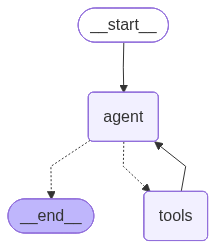

In [52]:
from deepagents import create_deep_agent

agent = create_deep_agent(
    sub_agent_tools,
    INSTRUCTIONS,
    subagents=[research_sub_agent],
    model=model,
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [53]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, and core concepts",              │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Investigate MCP architecture, components, and how it works",                                  │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Explore use cases, benefits, and real-world applications of MCP",                             │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research MCP implementation details and technical specifications",                            │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Compile comprehensive overview and present findings",                                         │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_1aababeabed341be96                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) - definition, purpose, and core        │
│ concepts', 'status': 'pending'}, {'content': 'Investigate MCP architecture, components, and how it works',      │
│ 'status': 'pending'}, {'content': 'Explore use cases, benefits, and real-world applications of MCP', 'status':  │
│ 'pending'}, {'content': 'Research MCP implementation details and technical specifications', 'status':           │
│ 'pending'}, {'content': 'Compile comprehensive overview and present findings', 'status': 'pending'}]            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, and core concepts",              │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Investigate MCP architecture, components, and how it works",                                  │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Explore use cases, benefits, and real-world applications of MCP",                             │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research MCP implementation details and technical specifications",                            │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Compile comprehensive overview and present findings",                                         │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_38a23b8af8a04d8f9c                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) - definition, purpose, and core        │
│ concepts', 'status': 'in_progress'}, {'content': 'Investigate MCP architecture, components, and how it works',  │
│ 'status': 'pending'}, {'content': 'Explore use cases, benefits, and real-world applications of MCP', 'status':  │
│ 'pending'}, {'content': 'Research MCP implementation details and technical specifications', 'status':           │
│ 'pending'}, {'content': 'Compile comprehensive overview and present findings', 'status': 'pending'}]            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research the Model Context Protocol (MCP) - provide detailed information about what MCP is,   │
│ its definition, purpose, core concepts, and who created it. Include information about its role in AI/ML systems │
│ and how it differs from other protocols.",                                                                      │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: call_1584bb248c1340de8a                                                                                  │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research MCP architecture and technical components - explain how MCP works, its key           │
│ components, communication patterns, and technical implementation details. Include information about protocols,  │
│ APIs, and how MCP facilitates communication between AI models and external systems.",                           │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: call_23cc524a63d2475d9c                                                                                  │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research MCP use cases, benefits, and real-world applications - provide examples of how MCP   │
│ is used in practice, its advantages over other approaches, and specific applications in AI development, model   │
│ deployment, and system integration.",                                                                           │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: call_c3b5f879585541d88d                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my research, here's a comprehensive overview of the Model Context Protocol (MCP):                      │
│                                                                                                                 │
│ ## What is Model Context Protocol (MCP)?                                                                        │
│                                                                                                                 │
│ **Definition**: MCP is an open-source standard introduced by Anthropic for connecting AI applications to        │
│ external systems, tools, and data sources. It's designed to standardize how AI models interact with external    │
│ resources.                                                                                                      │
│                                                                                                                 │
│ ## Purpose and Core Objectives                                                                                  │
│                                                                                                                 │
│ MCP was created to solve the "M×N integration problem" - where connecting M AI applications to N external       │
│ systems would require M×N individual integrations. MCP transforms this into an M+N problem by providing a       │
│ standardized protocol.                                                                                          │
│                                                                                                                 │
│ **Primary goals**:                                                                                              │
│ - Reduce development time and complexity for AI application integration                                         │
│ - Provide AI applications/agents access to an ecosystem of data sources, tools, and applications                │
│ - Enable composability and reusability of AI tool integrations                                                  │
│ - Establish clear security boundaries between AI models and external systems                                    │
│                                                                                                                 │
│ ## Core Concepts and Architecture                                                                               │
│                                                                                                                 │
│ **Client-Host-Server Model**:                                                                                   │
│ - **Clients**: AI applications or agents that need access to external tools/data                                │
│ - **Hosts**: Applications that manage the connection between clients and servers                                │
│ - **Servers**: Specialized services that provide specific tools, resources, or data                             │
│                                                                                                                 │
│ **Three Core Components**:                                                                                      │
│ 1. **Tools**: Model-controlled functions that AI can call to perform actions                                    │
│ 2. **Resources**: Application-controlled data sources that AI can access                                        │
│ 3. **Prompts**: User-controlled templates for structured interactions                                           │
│                                                                                                                 │
│ **Technical Foundation**:                                                                                       │
│ - Uses **JSON-RPC** for stateful communication sessions

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my research, here's a comprehensive overview of the Model Context Protocol (MCP) architecture and      │
│ technical components:                                                                                           │
│                                                                                                                 │
│ ## What is MCP?                                                                                                 │
│                                                                                                                 │
│ The **Model Context Protocol (MCP)** is an open-source standard developed by Anthropic that provides a          │
│ standardized way for AI applications (particularly Large Language Models) to communicate with external tools,   │
│ data sources, and services. It solves the "NxM integration problem" where each AI model would need custom       │
│ integrations with every external service.                                                                       │
│                                                                                                                 │
│ ## Key Components and Architecture                                                                              │
│                                                                                                                 │
│ ### 1. **Client-Server Architecture**                                                                           │
│ MCP follows a client-server model where:                                                                        │
│ - **MCP Clients**: AI applications or LLMs that need to access external functionality                           │
│ - **MCP Servers**: External services that provide tools, resources, or data                                     │
│                                                                                                                 │
│ ### 2. **Layered Architecture**                                                                                 │
│ MCP employs a two-layer architecture:                                                                           │
│                                                                                                                 │
│ **Data Layer (Application Layer)**                                                                              │
│ - Uses **JSON-RPC 2.0** protocol for structured communication                                                   │
│ - Handles three main types of interactions:                                                                     │
│   - **Tools**: Function calls that AI models can execute                                                        │
│   - **Resources**: Data sources that AI models can access                                                       │
│   - **Prompts**: Interactive dialogues with human oversight                                                     │
│                                                                                                                 │
│ **Transport Layer**                                                                                             │
│ - Supports multiple transport mechanisms:                                                                       │
│   - **stdio** (standard input/output) for local communication                                                   │
│   - **HTTP** for network-based communication                                                                    │
│   - Enables flexibility in deployment scenarios                                                                 │
│                                                                                                                 │
│ ## Communication Patterns and Protocols                

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my research, here's a comprehensive overview of MCP (Model Context Protocol) use cases, benefits, and  │
│ real-world applications:                                                                                        │
│                                                                                                                 │
│ ## What is MCP?                                                                                                 │
│ The Model Context Protocol (MCP) is an open protocol framework for standardizing interactions between large     │
│ language models (LLMs) and external tools/data sources. It provides a standardized way for AI systems to access │
│ and manage contextual information.                                                                              │
│                                                                                                                 │
│ ## Key Benefits and Advantages                                                                                  │
│                                                                                                                 │
│ ### **Primary Benefits:**                                                                                       │
│ - **Persistent Context Management**: MCP maintains context across multiple sessions, enabling better multi-turn │
│ conversations and continuity                                                                                    │
│ - **Modular Knowledge Injection**: Allows dynamic updates to knowledge bases without requiring model retraining │
│ - **Improved AI Coherence**: Enhances conversation flow and logical consistency in AI interactions              │
│ - **Enhanced Transparency**: Provides clearer visibility into how AI systems access and use contextual          │
│ information                                                                                                     │
│ - **Personalization Capabilities**: Enables tailored experiences based on user history and preferences          │
│                                                                                                                 │
│ ### **Advantages Over Other Approaches:**                                                                       │
│ - **30% Development Time Reduction**: Compared to custom integration solutions                                  │
│ - **25% Maintenance Cost Reduction**: Over traditional custom-built systems                                     │
│ - **Real-time Communication**: Supports dynamic discovery and real-time data access                             │
│ - **Standardized Protocol**: Eliminates vendor lock-in and promotes interoperability                            │
│ - **Scalability**: Designed for building modular, scalable AI workflows                                         │
│                                                                                                                 │
│ ## Real-World Applications and Use Cases                                                                        │
│                                                                                                                 │
│ ### **AI Development Applications:**                                                                            │
│ 1. **Multi-language Development**: Microsoft's open-source MCP curriculum supports .NET, Java, TypeScript,      │
│ JavaScript, Rust, and Python                                                                                    │
│ 2. **Rapid Prototyping**: Enables faster development of AI applications with standardized tool integration      │
│ 3. **Testing and Validation**: Provides consistent frameworks for testing AI model interactions                 │
│                                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, and core concepts",              │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Investigate MCP architecture, components, and how it works",                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Explore use cases, benefits, and real-world applications of MCP",                             │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research MCP implementation details and technical specifications",                            │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Compile comprehensive overview and present findings",                                         │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_23dd1538838545c584                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) - definition, purpose, and core        │
│ concepts', 'status': 'completed'}, {'content': 'Investigate MCP architecture, components, and how it works',    │
│ 'status': 'completed'}, {'content': 'Explore use cases, benefits, and real-world applications of MCP',          │
│ 'status': 'completed'}, {'content': 'Research MCP implementation details and technical specifications',         │
│ 'status': 'in_progress'}, {'content': 'Compile comprehensive overview and present findings', 'status':          │
│ 'pending'}]                                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research MCP implementation details, technical specifications, and how to implement MCP       │
│ servers and clients. Include information about JSON-RPC protocol usage, transport mechanisms (stdio/HTTP),      │
│ security considerations, and practical implementation examples.",                                               │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: call_c619ed81e9924844a3                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my research, I can provide you with comprehensive information about MCP (Model Context Protocol)       │
│ implementation details, technical specifications, and practical implementation guidance.                        │
│                                                                                                                 │
│ ## MCP Overview and Architecture                                                                                │
│                                                                                                                 │
│ The Model Context Protocol (MCP) is a client-server protocol designed for AI applications to exchange context   │
│ with external services. It follows a layered architecture:                                                      │
│                                                                                                                 │
│ **Data Layer**: JSON-RPC protocol handling tools, resources, and prompts                                        │
│ **Transport Layer**: stdio or Streamable HTTP for communication                                                 │
│                                                                                                                 │
│ ## JSON-RPC Protocol Implementation                                                                             │
│                                                                                                                 │
│ MCP uses JSON-RPC 2.0 as its core protocol with specific message types:                                         │
│                                                                                                                 │
│ ### Key JSON-RPC Methods:                                                                                       │
│ - **tools/list** - Discover available tools                                                                     │
│ - **tools/call** - Execute tools with parameters                                                                │
│ - **resources/list** - List available resources                                                                 │
│ - **resources/read** - Read resource content                                                                    │
│ - **prompts/list** - List available prompts                                                                     │
│ - **prompts/get** - Retrieve prompt templates                                                                   │
│                                                                                                                 │
│ ### Protocol Features:                                                                                          │
│ - Capability negotiation system                                                                                 │
│ - Real-time notifications for dynamic tool discovery                                                            │
│ - Structured error handling with error codes                                                                    │
│ - Session management capabilities                                                                               │
│                                                                                                                 │
│ ## Transport Mechanisms                                                                                         │
│                                                                                                                 │
│ ### 1. stdio Transport                                                                                          │
│ - **Primary transport** for local deployments                                                                   │
│ - Simple pipe-based communication                      

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, and core concepts",              │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Investigate MCP architecture, components, and how it works",                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Explore use cases, benefits, and real-world applications of MCP",                             │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research MCP implementation details and technical specifications",                            │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Compile comprehensive overview and present findings",                                         │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_7b2566f16b6f40feab                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) - definition, purpose, and core        │
│ concepts', 'status': 'completed'}, {'content': 'Investigate MCP architecture, components, and how it works',    │
│ 'status': 'completed'}, {'content': 'Explore use cases, benefits, and real-world applications of MCP',          │
│ 'status': 'completed'}, {'content': 'Research MCP implementation details and technical specifications',         │
│ 'status': 'completed'}, {'content': 'Compile comprehensive overview and present findings', 'status':            │
│ 'in_progress'}]                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "content": "# Model Context Protocol (MCP) - Comprehensive Overview\n\n## What is Model Context Protocol      │
│ (MCP)?\n\n**Model Context Protocol (MCP)** is an open-source standard developed by Anthropic that provides a    │
│ standardized way for AI applications (particularly Large Language Models) to communicate with external tools,   │
│ data sources, and services. It solves the \"N×M integration problem\" where each AI model would need custom     │
│ integrations with every external service.\n\n## Core Purpose and Objectives\n\nMCP was created to:\n-           │
│ **Standardize AI tool integration** - Provide a unified protocol instead of custom integration code for each    │
│ service\n- **Enable composability** - Tools and resources can be combined across different servers\n-           │
│ **Establish security boundaries** - Clear separation between AI models and external services\n- **Reduce        │
│ development complexity** - Transform M×N integrations into M+N problem\n\n## Key Architectural                  │
│ Components\n\n### Client-Server Architecture\n- **MCP Clients**: AI applications or LLMs that need external     │
│ functionality\n- **MCP Servers**: External services providing tools, resources, or data\n\n### Three Core       │
│ Interaction Types\n1. **Tools**: Model-controlled functions that AI can call to perform actions\n2.             │
│ **Resources**: Application-controlled data sources that AI can access\n3. **Prompts**: User-controlled          │
│ templates for structured interactions\n\n### Communication Protocol\n- Uses **JSON-RPC 2.0** for structured     │
│ communication\n- Supports multiple transport mechanisms: **stdio** (local) and **HTTP** (network)\n- Implements │
│ capability negotiation and dynamic tool discovery\n\n## Technical Implementation Details\n\n### Protocol        │
│ Features\n- **Dynamic tool discovery** - AI models discover available tools at runtime\n- **Real-time data      │
│ access** - Enables LLMs to access current information\n- **Standardized function calling** - Consistent         │
│ interface across AI systems\n- **Security boundaries** - Servers cannot access full conversation history\n\n### │
│ Security Considerations\n- DNS rebinding protection required\n- OAuth-based authentication recommended\n- Input │
│ validation and access control\n- Transport security (HTTPS for HTTP transport)\n\n## Benefits and               │
│ Advantages\n\n### Primary Benefits\n- **30% development time reduction** compared to custom integrations\n-     │
│ **25% maintenance cost reduction** over traditional systems\n- **Persistent context management** across         │
│ multiple sessions\n- **Improved AI coherence** and conversation flow\n- **Enhanced transparency** in AI system  │
│ operations\n\n### Advantages Over Alternatives\n- **AI-native design** specifically for model interactions\n-   │
│ **Open standard** not tied to any single vendor\n- **Composable architecture** for tool/resource mixing\n-      │
│ **Security-first approach** with clear boundaries\n\n## Real-World Applications\n\n### AI Development\n-        │
│ Multi-language support (Python, JavaScript, .NET, Java, Rust)\n- Rapid prototyping of AI applications\n-        │
│ Testing and validation frameworks\n\n### Enterprise Deployment\n- Customer service chatbots with persistent     │
│ memory\n- Knowledge management systems with dynamic upda

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /mcp_overview.md                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, and core concepts",              │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Investigate MCP architecture, components, and how it works",                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Explore use cases, benefits, and real-world applications of MCP",                             │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research MCP implementation details and technical specifications",                            │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Compile comprehensive overview and present findings",                                         │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_9fb937d5d6934909a0                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) - definition, purpose, and core        │
│ concepts', 'status': 'completed'}, {'content': 'Investigate MCP architecture, components, and how it works',    │
│ 'status': 'completed'}, {'content': 'Explore use cases, benefits, and real-world applications of MCP',          │
│ 'status': 'completed'}, {'content': 'Research MCP implementation details and technical specifications',         │
│ 'status': 'completed'}, {'content': 'Compile comprehensive overview and present findings', 'status':            │
│ 'completed'}]                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ # Model Context Protocol (MCP) - Comprehensive Overview                                                         │
│                                                                                                                 │
│ Based on my research, here's a detailed overview of the Model Context Protocol (MCP):                           │
│                                                                                                                 │
│ ## What is Model Context Protocol (MCP)?                                                                        │
│                                                                                                                 │
│ **MCP** is an open-source standard developed by **Anthropic** that provides a standardized way for AI           │
│ applications (particularly Large Language Models) to communicate with external tools, data sources, and         │
│ services. It was specifically designed to solve the "N×M integration problem" where connecting M AI             │
│ applications to N external systems would require M×N individual integrations.                                   │
│                                                                                                                 │
│ ## Core Purpose and Key Benefits                                                                                │
│                                                                                                                 │
│ ### Primary Objectives:                                                                                         │
│ - **Standardize AI tool integration** - Create a unified protocol instead of custom code for each service       │
│ - **Enable composability** - Tools and resources can be mixed and matched across different servers              │
│ - **Establish security boundaries** - Clear separation between AI models and external services                  │
│ - **Reduce development complexity** - Transform complex integration problems into manageable solutions          │
│                                                                                                                 │
│ ### Key Benefits:                                                                                               │
│ - **30% development time reduction** compared to custom integrations                                            │
│ - **25% maintenance cost reduction** over traditional systems                                                   │
│ - **Persistent context management** across multiple sessions                                                    │
│ - **Improved AI coherence** and conversation flow                                                               │
│                                                                                                                 │
│ ## Architecture and Technical Components                                                                        │
│                                                                                                                 │
│ ### Client-Server Model:                                                                                        │
│ - **MCP Clients**: AI applications or LLMs needing external functionality                                       │
│ - **MCP Servers**: External services providing tools, resources, or data                                        │
│                                                                                                                 │
│ ### Three Core Interaction Types:                                                                               │
│ 1. **Tools**: Model-controlled functions that AI can call to perform actions                                    │
│ 2. **Resources**: Application-controlled data sources t

Trace: 
https://smith.langchain.com/public/1d626d81-a102-4588-a2fb-cab40a7271f1/r
<!-- https://smith.langchain.com/public/1ae2d7f6-f901-4ebd-b6c3-6657a55f88ae/r -->